# Analysis of Stack Overflow Survey Responses about Remote Work

### Table of Contents
1. [Business Understanding](#1.-Business-Understanding)


2. [Data Understanding](#2.-Data-Understanding)
    
    2.1. [Inspect HomeRemote Column](#2.1-Inspect-HomeRemote-Column)
    
    2.2. [Inspect Salary Column](#2.2-Inspect-Salary-Column)

    2.3. [Inspect Job/Career Satisfaction Columns](#2.3-Inspect-Job/Career-Satisfaction-Columns)
    
    
3. [Prepare Data](#3.-Prepare-Data)

### 1. Business Understanding

This analysis is motivated by the following business questions:
* How does remote vs. office work relate to salary?
* How does remote vs. office work relate to job/career satisfaction?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns
import os
import pprint
import column_rename_dicts as crd
from so_analysis_functions import collapse_cat_and_dummy, get_description, df_missingness_stats, recode_null_not_null_as_0_1
%matplotlib inline
pd.options.display.max_seq_items = 500
pd.options.display.float_format = '{:,}'.format

In [2]:
#regex patterns needed in data cleaning
date_pattern = r"^([1-9]|1[012])[- /.]([1-9]|[12][0-9]|3[01])[- /.](19|20)\d\d$"

In [3]:
#Load Data
df_2017 = pd.read_csv('./so-survey-2017/survey_results_public.csv')
schema_2017 = pd.read_csv('./so-survey-2017/survey_results_schema.csv')

### 2. Data Understanding
As a first step in answering these questions, we will look at the 2017 Stack 
Overflow Survey results. For these questions, we focus on the 
column `HomeRemote`, which corresponds to the following question:

> How often do you work from home or remotely?

The first question looks at the relationship between `HomeRemote` and 
`Salary`, which corresponds to the question:

> What is your current annual base salary, before taxes, and excluding bonuses, grants, or other compensation?

The second question looks at the relationship between `HomeRemote` and two measures of satisfaction at work: `JobSatisfaction` and `CareerSatisfaction` which each ask the respondent to rate on a scale of 1 (least) to 10 (most) their satisfaction with their job and their career, respectively.

In [4]:
df_missingness_stats(df_2017, '2017')

Number of Rows in 2017 data: 51392
Number of Columns in 2017 data: 154
Number of Columns in 2017 data with no missing values: 7
Number of Columns in 2017 data with > 75% missing values: 14
Number of Columns in 2017 data with all missing values: 0
Columns in 2017 data with no missing values: {'ProgramHobby', 'Country', 'University', 'Professional', 'FormalEducation', 'EmploymentStatus', 'Respondent'}
Columns in 2017 data with > 75% missing values: {'ExCoderBelonged', 'ExpectedSalary', 'MobileDeveloperType', 'ExCoderActive', 'ExCoderSkills', 'ExCoderNotForMe', 'ExCoderReturn', 'ExCoderBalance', 'ExCoder10Years', 'WebDeveloperType', 'YearsCodedJobPast', 'ExCoderWillNotCode', 'TimeAfterBootcamp', 'NonDeveloperType'}


#### 2.1 Inspect HomeRemote Column

In [5]:
df_2017['HomeRemote'].value_counts(dropna=False)

A few days each month                                      15454
Never                                                      13975
NaN                                                         7384
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each week     4147
More than half, but not all, the time                       1909
It's complicated                                            1849
About half the time                                         1769
Name: HomeRemote, dtype: int64

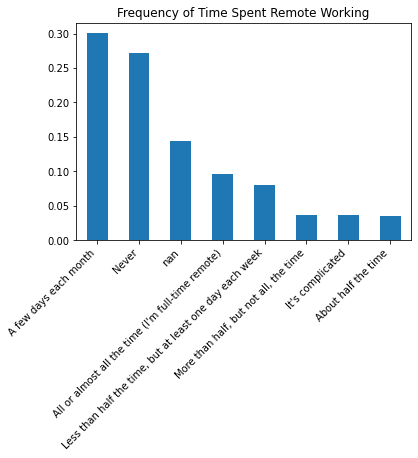

In [6]:
home_remote_value_counts = df_2017['HomeRemote'].value_counts(dropna=False)
hr_value_counts_plt = (home_remote_value_counts/df_2017.shape[0]).plot(kind="bar")
plt.title("Frequency of Time Spent Remote Working")
hr_value_counts_plt.set_xticklabels(hr_value_counts_plt.get_xticklabels()
, rotation=45
, horizontalalignment='right')
plt.show()

In [7]:
df_2017['HomeRemote'].isnull().sum()/df_2017.shape[0]

0.1436799501867995

In [8]:
df_2017['HomeRemote_missing'] = df_2017['HomeRemote'].isna()

#### 2.2 Inspect Salary Column

In [9]:
df_2017['Salary'].value_counts(dropna=False)

nan                    38501
120,000.0                167
110,000.0                164
100,000.0                155
75,000.0                 149
                       ...  
77,322.0                   1
76,095.02598366741         1
14,262.132717068302        1
33,057.8512396694          1
77,700.0                   1
Name: Salary, Length: 3050, dtype: int64

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


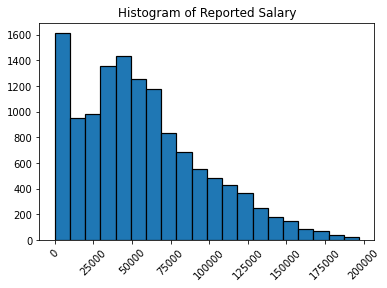

In [10]:
plt.hist(df_2017['Salary'], bins=20, edgecolor='black', linewidth=1.2)
plt.title("Histogram of Reported Salary")
plt.xticks(rotation=45)
plt.show()


In [12]:
df_2017['Salary_Imputed'] = df_2017['Salary'].fillna(df_2017['Salary'].mean()) #Fill all missing values with the mean of the column.

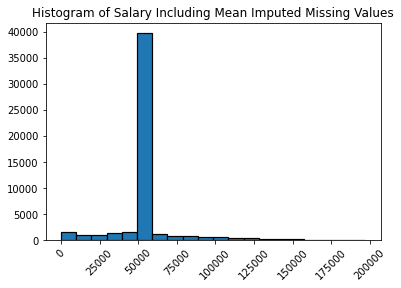

In [13]:
plt.hist(df_2017['Salary_Imputed'], bins=20, edgecolor='black', linewidth=1.2)
plt.title("Histogram of Salary Including Mean Imputed Missing Values")
plt.xticks(rotation=45)
plt.show()

#### 2.3 Inspect Job/Career Satisfaction Columns

In [14]:
df_2017['JobSatisfaction'].value_counts(dropna=False)

nan     11016
8.0      8983
7.0      7969
9.0      5573
6.0      4726
10.0     4148
5.0      3749
4.0      1865
3.0      1635
2.0       888
0.0       467
1.0       373
Name: JobSatisfaction, dtype: int64

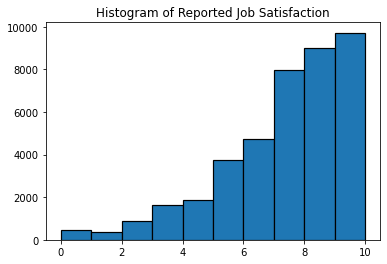

In [15]:
plt.hist(df_2017['JobSatisfaction'], bins=10, edgecolor='black', linewidth=1.2)
plt.title("Histogram of Reported Job Satisfaction")
plt.show()

In [16]:
# Fill all missing values with the mode of the column.
df_2017['JobSatisfaction_Imputed'] = df_2017['JobSatisfaction'].fillna(df_2017['JobSatisfaction'].mean()) 

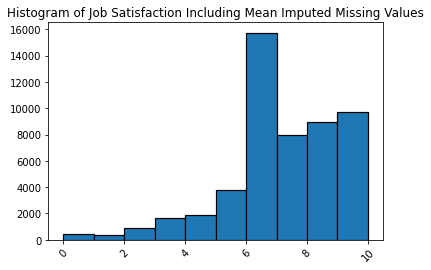

In [17]:
plt.hist(df_2017['JobSatisfaction_Imputed'], bins=10, edgecolor='black', linewidth=1.2)
plt.title("Histogram of Job Satisfaction Including Mean Imputed Missing Values")
plt.xticks(rotation=45)
plt.show()

### 3. Prepare Data
All three of the columns of interest require preparation, since the the columns 
of interest are categorical, and have missing data.

In [18]:
# Create different definitions for a remote worker
# Strict definition: A remote worker is one that is full-time remote
# Lax definition: A remote worker is one that spends at least one
# day a week working remotely. 
# In either case, if are implicitly imputing missing values by treating them 
# as if they were the modal response ("A few days each month"). Both defin
remote_worker_strict_list = ["All or almost all the time (I'm full-time remote)"]
remote_worker_lax_list = ["All or almost all the time (I'm full-time remote)", "Less than half the time, but at least one day each week", "More than half, but not all, the time", "About half the time"]

In [19]:
# Collapse and dummy HomeRemote and DiversityImportant columns
df_2017['RemoteWorker_Strict']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(remote_worker_strict_list,))
df_2017['RemoteWorker_Lax']=df_2017['HomeRemote'].apply(collapse_cat_and_dummy, args=(remote_worker_lax_list,))

In [20]:
# Check that function works
assert df_2017['RemoteWorker_Strict'].sum() == home_remote_value_counts.filter(items=remote_worker_strict_list).sum()
assert df_2017['RemoteWorker_Lax'].sum() == home_remote_value_counts.filter(items=remote_worker_lax_list).sum()

In [21]:
remote_strict_1 = df_2017[df_2017['RemoteWorker_Strict'] == 1] # Subset df to only those with RemoteWorker_Strict of 1
remote_strict_0 = df_2017[df_2017['RemoteWorker_Strict'] == 0] # Subset df to only those with RemoteWorker_Strict of 0

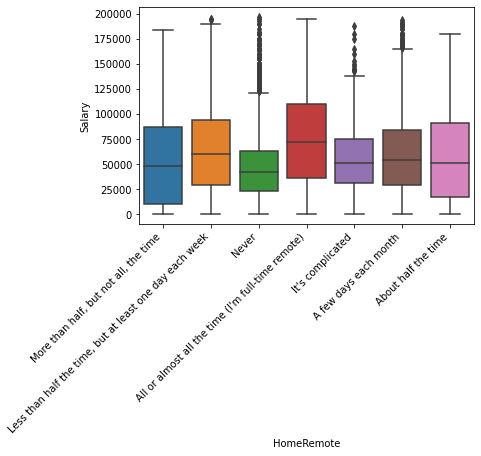

In [22]:
boxplot = sns.boxplot(y='Salary', x='HomeRemote', data=df_2017)
boxplot.set_xticklabels(boxplot.get_xticklabels()
, rotation=45
, horizontalalignment='right')
plt.show()

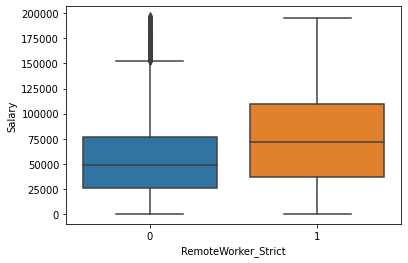

In [23]:
sns.boxplot(y='Salary', x='RemoteWorker_Strict', data=df_2017)
plt.show()


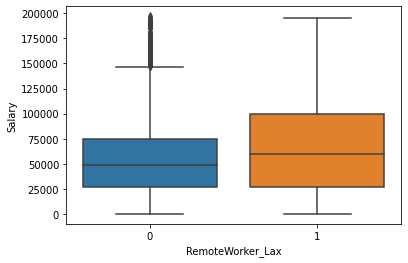

In [24]:
sns.boxplot(y='Salary', x='RemoteWorker_Lax', data=df_2017)
plt.show()

In [25]:
job_sat_remote_strict_1 = remote_strict_1['JobSatisfaction'].value_counts(dropna=False)/remote_strict_1.shape[0]
job_sat_remote_strict_0 = remote_strict_0['JobSatisfaction'].value_counts(dropna=False)/remote_strict_0.shape[0]
career_sat_remote_strict_1 = remote_strict_1['CareerSatisfaction'].value_counts(dropna=False)/remote_strict_1.shape[0]
career_sat_remote_strict_0 = remote_strict_0['CareerSatisfaction'].value_counts(dropna=False)/remote_strict_0.shape[0]

In [26]:
comp_df = pd.concat([job_sat_remote_strict_1, job_sat_remote_strict_0], axis=1)
comp_df.columns = ['job_sat_remote_strict_1', 'job_sat_remote_strict_0']
comp_df['Diff_Remote_Strict_Vals'] = comp_df['job_sat_remote_strict_1'] - comp_df['job_sat_remote_strict_0']
comp_df.style.bar(subset=['Diff_Remote_Strict_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])


,job_sat_remote_strict_1,job_sat_remote_strict_0,Diff_Remote_Strict_Vals
0.0,0.010398,0.008949,0.001449
1.0,0.006932,0.007292,-0.000361
2.0,0.012844,0.017747,-0.004903
3.0,0.028338,0.032181,-0.003843
4.0,0.028542,0.037107,-0.008565
5.0,0.070744,0.073182,-0.002438
6.0,0.087054,0.092477,-0.005423
7.0,0.153517,0.155226,-0.001709
8.0,0.186748,0.173532,0.013216
9.0,0.144546,0.104631,0.039915


In [27]:
comp_df = pd.concat([career_sat_remote_strict_1, career_sat_remote_strict_0], axis=1)
comp_df.columns = ['career_sat_remote_strict_1', 'career_sat_remote_strict_0']
comp_df['Diff_Remote_Strict_Vals'] = comp_df['career_sat_remote_strict_1'] - comp_df['career_sat_remote_strict_0']
comp_df.style.bar(subset=['Diff_Remote_Strict_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])


,career_sat_remote_strict_1,career_sat_remote_strict_0,Diff_Remote_Strict_Vals
0.0,0.004485,0.007959,-0.003474
1.0,0.003874,0.004130,-0.000257
2.0,0.008155,0.009788,-0.001633
3.0,0.016514,0.020758,-0.004245
4.0,0.023038,0.026653,-0.003615
5.0,0.055657,0.060167,-0.004510
6.0,0.082977,0.092800,-0.009824
7.0,0.173089,0.183600,-0.010511
8.0,0.218145,0.214404,0.003741
9.0,0.132518,0.106030,0.026488
